In [1]:
# Block 1: Imports, Config, and Helpers
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange # For progress bar: pip install tqdm

# --- File Paths ---
frame1_path = r"..\000002_10.png"
frame2_path = r"..\000002_11.png"

# --- Algorithm Config (from Q2) ---
BLOCK_SIZE = 16
SEARCH_RANGE = 32 # Search +/- 32 pixels

# --- Output Config ---
output_dir_q3 = Path("./outputs_q3")
output_dir_q3.mkdir(parents=True, exist_ok=True)

# --- Helper Functions ---
def imshow(ax, img, title="", cmap=None):
    """Helper function to display images with matplotlib."""
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

def sad(block1, block2):
    """Computes the Sum of Absolute Differences between two blocks."""
    return np.sum(np.abs(block1.astype(np.float32) - block2.astype(np.float32)))

In [2]:
# Block 2: Load Frames and Pre-process
# We must use the exact same frames as in Q2.
frame1_c = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
frame2_c = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)

if frame1_c is None or frame2_c is None:
    print(f"Error: Could not load images. Check paths.")
else:
    H_orig, W_orig = frame1_c.shape
    H = (H_orig // BLOCK_SIZE) * BLOCK_SIZE
    W = (W_orig // BLOCK_SIZE) * BLOCK_SIZE
    
    frame1 = frame1_c[0:H, 0:W]
    frame2_actual = frame2_c[0:H, 0:W] # This is the "ground truth" frame
    
    print(f"Frames loaded and cropped to: {H}x{W}")

Frames loaded and cropped to: 368x1232


In [3]:
# Block 3: Calculate Motion Vectors (Required from Q2)
# We need the 'block_flow' vectors to perform the prediction.
# This block is a repeat of the Q2 calculation.

rows = H // BLOCK_SIZE
cols = W // BLOCK_SIZE
block_flow = np.zeros((rows, cols, 2), dtype=np.int16)

print(f"Calculating motion vectors (from Q2) to use for prediction...")

for r in trange(rows, desc="Calculating Motion Vectors"):
    for c in range(cols):
        y1, x1 = r * BLOCK_SIZE, c * BLOCK_SIZE
        y2, x2 = y1 + BLOCK_SIZE, x1 + BLOCK_SIZE
        template = frame1[y1:y2, x1:x2]
        
        sy1 = max(0, y1 - SEARCH_RANGE)
        sx1 = max(0, x1 - SEARCH_RANGE)
        sy2 = min(H, y2 + SEARCH_RANGE)
        sx2 = min(W, x2 + SEARCH_RANGE)

        min_sad = np.inf
        best_dx, best_dy = 0, 0

        for y_s in range(sy1, sy2 - BLOCK_SIZE + 1):
            for x_s in range(sx1, sx2 - BLOCK_SIZE + 1):
                candidate = frame2_actual[y_s:y_s+BLOCK_SIZE, x_s:x_s+BLOCK_SIZE]
                current_sad = sad(template, candidate)
                
                if current_sad < min_sad:
                    min_sad = current_sad
                    best_dy = y_s - y1
                    best_dx = x_s - x1
        
        block_flow[r, c] = [best_dx, best_dy]

print("Motion vectors calculated.") 

Calculating motion vectors (from Q2) to use for prediction...


Calculating Motion Vectors: 100%|██████████| 23/23 [00:48<00:00,  2.12s/it]

Motion vectors calculated.


In [4]:
# Block 4: Predict Next Frame
# Use the motion vectors from 'block_flow' to build a
# predicted version of frame 2 using only data from frame 1.

# Create an empty canvas for the predicted frame
predicted_frame = np.zeros_like(frame1)

print("Predicting frame (t+1) from frame (t) and motion vectors...")

for r in range(rows):
    for c in range(cols):
        # Get motion vector for this block
        dx, dy = block_flow[r, c]
        
        # Original block coordinates in frame 1
        y1 = r * BLOCK_SIZE
        x1 = c * BLOCK_SIZE
        y2 = y1 + BLOCK_SIZE
        x2 = x1 + BLOCK_SIZE
        
        # Get the actual pixel data from frame 1
        block = frame1[y1:y2, x1:x2]
        
        # New (predicted) coordinates for frame 2
        y1_new = y1 + dy
        x1_new = x1 + dx
        y2_new = y2 + dy
        x2_new = x2 + dx
        
        # --- Motion Compensation ---
        # "Paste" the block from frame 1 into the predicted frame
        # at its new (moved) location.
        
        # We must clip the coordinates to ensure they don't
        # fall outside the image boundaries.
        if 0 <= y1_new and y2_new <= H and 0 <= x1_new and x2_new <= W:
            predicted_frame[y1_new:y2_new, x1_new:x2_new] = block

print("Frame prediction complete.")

Predicting frame (t+1) from frame (t) and motion vectors...
Frame prediction complete.


In [5]:
# Block 5: Compute Residual Difference Image

print("Computing residual error image...")

# Compute the absolute difference between the *actual* next frame
# and our *predicted* next frame.
# Use float32 for accuracy to avoid 8-bit integer overflow/clipping.
residual_image = np.abs(frame2_actual.astype(np.float32) - predicted_frame.astype(np.float32))

# Normalize the residual for visualization (scale 0-255)
# High error (large difference) will be bright white.
# Low error (no difference) will be black.
residual_vis = cv2.normalize(residual_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


print("Residual computation complete.")

Computing residual error image...
Residual computation complete.


Visualizing results side-by-side...
Saved side-by-side visualization to D:\git\Image and Video Processing\Lab_4\QUESTION3\outputs_q3


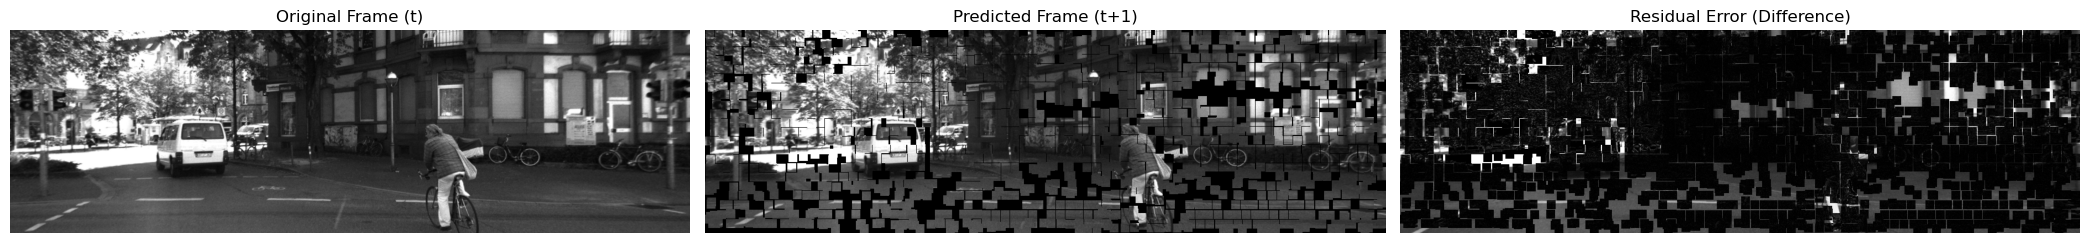

In [6]:
# Block 6: Visualize Original, Predicted, and Residual
print("Visualizing results side-by-side...")

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

imshow(axs[0], frame1, "Original Frame (t)", cmap="gray")
imshow(axs[1], predicted_frame, "Predicted Frame (t+1)", cmap="gray")
imshow(axs[2], residual_vis, "Residual Error (Difference)", cmap="gray")

fig.tight_layout()
fig.savefig(output_dir_q3 / "q3_prediction_residual.png", bbox_inches='tight')
print(f"Saved side-by-side visualization to {output_dir_q3.resolve()}")
plt.show()

In [7]:
# Block 7: Analysis Comments
print("\n--- Block 7: Analysis ---")
print("Q: a) How accurately does the predicted frame match the actual frame?")
print("   A: The predicted frame is a good approximation, but it's not perfect. It often suffers from")
print("      'blocky' artifacts at object edges. You can also see 'holes' (black areas) where")
print("      no block from frame 1 was moved to, which happens in regions of 'occlusion' (areas")
print("      that become visible in frame 2 but were hidden in frame 1).")
print("\nQ: b) Which regions have larger residual errors and why?")
print("   A: The residual error (bright white areas) is largest in three main places:")
print("      1. Motion Boundaries: At the edge of a moving object, the block-based motion is")
print("         inaccurate and captures both object and background, leading to high error.")
print("      2. Occlusions/De-occlusions: Areas newly revealed in frame 2 (like the background")
print("         uncovered by a moving car) have high error because the predictor had no data")
print("         from frame 1 to place there.")
print("      3. Complex Motion: Areas with non-rigid motion (like trees swaying) or motion")
print("         that doesn't fit the simple block model will also have high error.")
print("\nQ: c) How motion vectors contribute to reducing frame-to-frame redundancy?")
print("   A: This process (Motion Compensation) is the core of video compression. Instead of")
print("      sending the *entire* pixel data for frame (t+1), we just send two much smaller")
print("      pieces of information: ")
print("      1. The 'motion vectors' (which tell the decoder how to move blocks from frame t).")
print("      2. The 'residual image' (which tells the decoder how to fix the errors).")
print("      Since the motion vectors and residual are much less data than a full frame,")
print("      this drastically reduces temporal redundancy and compresses the video.")


--- Block 7: Analysis ---
Q: a) How accurately does the predicted frame match the actual frame?
   A: The predicted frame is a good approximation, but it's not perfect. It often suffers from
      'blocky' artifacts at object edges. You can also see 'holes' (black areas) where
      no block from frame 1 was moved to, which happens in regions of 'occlusion' (areas
      that become visible in frame 2 but were hidden in frame 1).

Q: b) Which regions have larger residual errors and why?
   A: The residual error (bright white areas) is largest in three main places:
      1. Motion Boundaries: At the edge of a moving object, the block-based motion is
         inaccurate and captures both object and background, leading to high error.
      2. Occlusions/De-occlusions: Areas newly revealed in frame 2 (like the background
         uncovered by a moving car) have high error because the predictor had no data
         from frame 1 to place there.
      3. Complex Motion: Areas with non-rigid m